# Create a dictionary of Sidpy Datasets to use for training a Neural Network

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib ipympl

import secrets
from PIL import Image
from ase.io import read
from ase.visualize import view

import sidpy

import abtem
from abtem.atoms import orthogonalize_cell

import pyTEMlib.probe_tools as pt

sys.path.append('/Users/austin/Documents/GitHub/pystemsim/pystemsim')
import data_generator as dg

%load_ext autoreload
%autoreload 2


You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled


## 1. Make the structure

In [2]:
pixel_size = 0.106 # angstrom/pixel

Text(0.5, 1.0, 'Atomic positions with field of view')

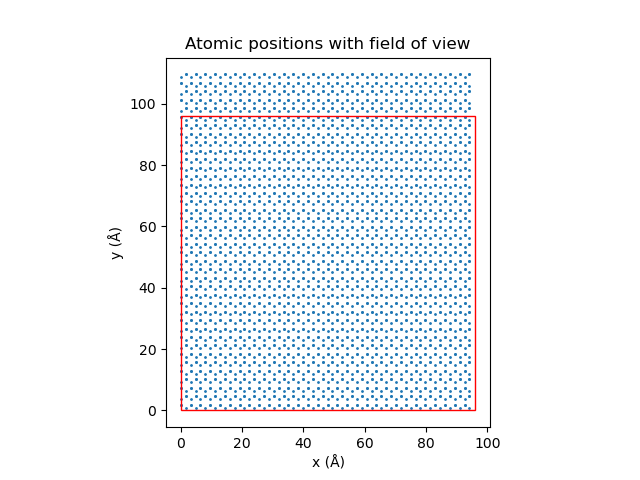

In [3]:
xtal = read('./crystal_files/WS2.cif')
xtal, transform = orthogonalize_cell(xtal, allow_transform=True, return_transform=True)
# be wary of non-physical transformations

xtal = xtal * (30, 20, 1)
positions = xtal.get_positions()[:, :2]

fov = 96 # angstroms
frame = (0,fov,0,fov) # limits of the image in angstroms

plt.figure()
plt.scatter(positions[:,0], positions[:,1], s=1)
square = patches.Rectangle((frame[0], frame[2]),frame[1] - frame[0],frame[3] - frame[2],edgecolor='red',facecolor='none')
plt.gca().add_patch(square)
plt.gca().set_aspect('equal')
plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("Atomic positions with field of view")


In [4]:
# read
xtal = read('./crystal_files/WS2.cif')

# orthoganalize
xtal, transform = orthogonalize_cell(xtal, allow_transform=True, return_transform=True)
# be wary of non-physical transformations

# extend
xtal = xtal * (30, 20, 1)

# rotate (pbc not maintained)
angle = 48
xtal = dg.rotate_xtal(xtal, angle)

# thermal vibrations
sigma = 0.1
xtal.rattle(stdev = sigma)

# induce vacancies
n_vacancies = 20
n_atoms = len(xtal.get_atomic_numbers())
vacancies = np.random.choice(n_atoms, n_vacancies, replace=False)
del xtal[vacancies]

# antisite defects
n_antisites = 10
# from ase.neighborlist import NeighborList


## 2. Make the images and labels

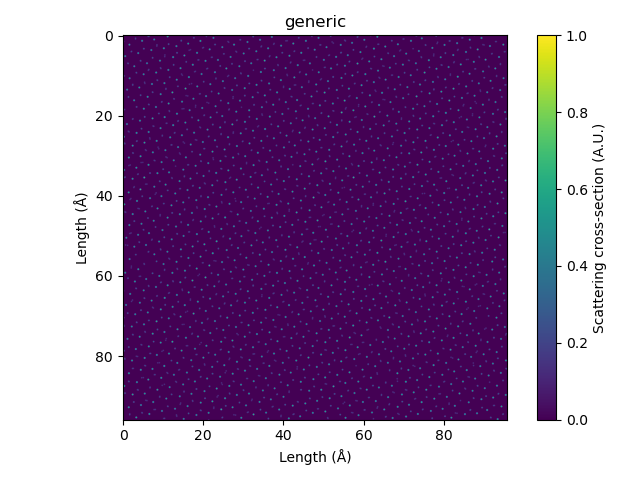

In [5]:
potential = dg.create_pseudo_potential(xtal, pixel_size, sigma=1, bounds=frame, atom_frame=11)

view = potential.plot()

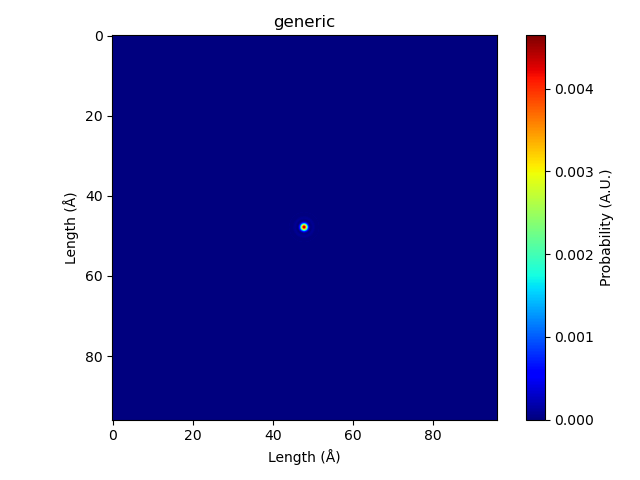

In [6]:
# Make point spread function
psf = dg.airy_disk(potential, resolution = 1.1)

view = psf.plot(cmap='jet')

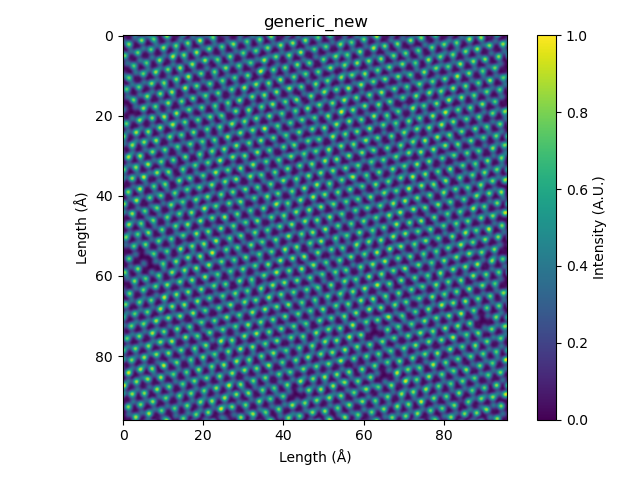

In [7]:
perfect_image = dg.convolve_kernel(potential, psf)

view = perfect_image.plot()

### Let's try with real aberrations

In [15]:
import pyTEMlib.probe_tools as pt
ab = pt.get_target_aberrations("Spectra300", 60000)
ab['acceleration_voltage'] = 60e3 # eV
ab['FOV'] = fov /12 # Angstroms
ab['convergence_angle'] = 30 # mrad
ab['wavelength'] = pt.get_wavelength(ab['acceleration_voltage'])
ab['C10'] = 1
ab['C23a'] = 2
pt.print_aberrations(ab)

0.03


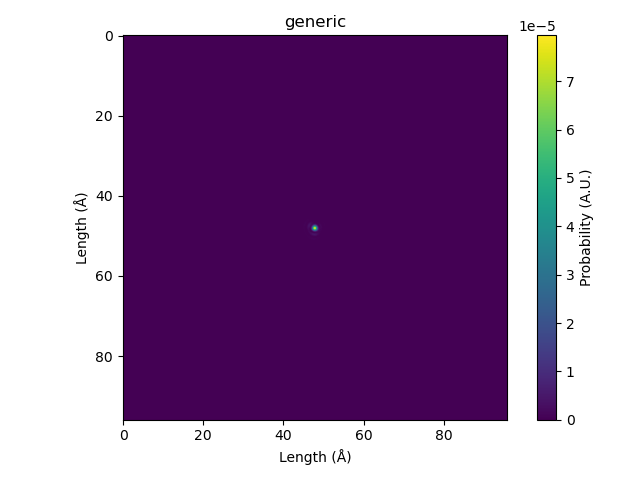

In [9]:
probe = dg.get_probe(ab, potential)

view = probe.plot()

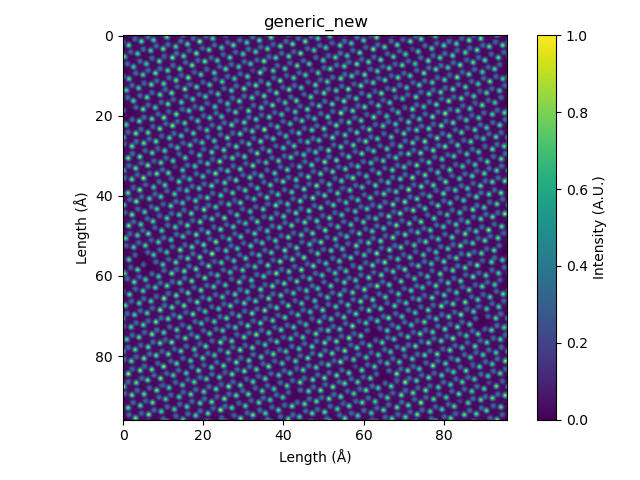

In [16]:
perfect_image = dg.convolve_kernel(potential, probe)

view = perfect_image.plot()

### Add noise

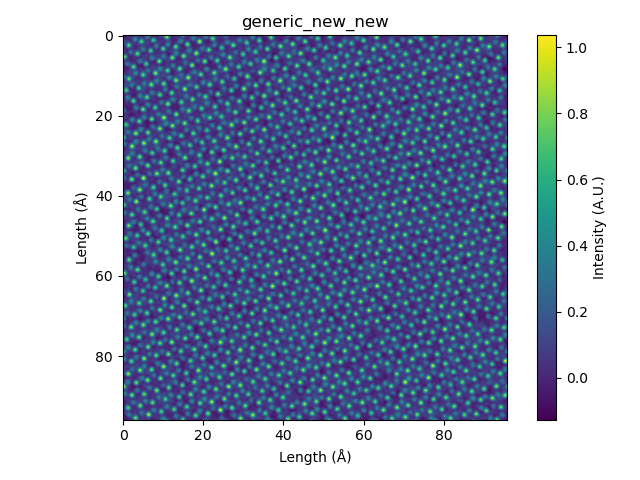

In [17]:
noisy_image = dg.lowfreq_noise(perfect_image, noise_level=0.5, freq_scale=.04)

view = noisy_image.plot()

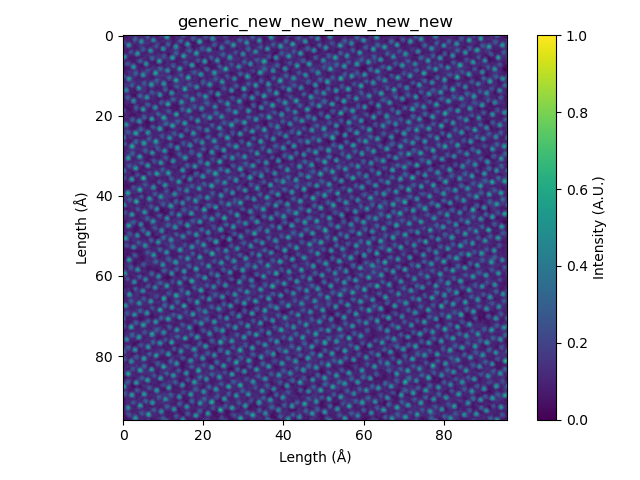

In [18]:
sim_im = dg.poisson_noise(noisy_image, counts=1e7)

view = sim_im.plot()

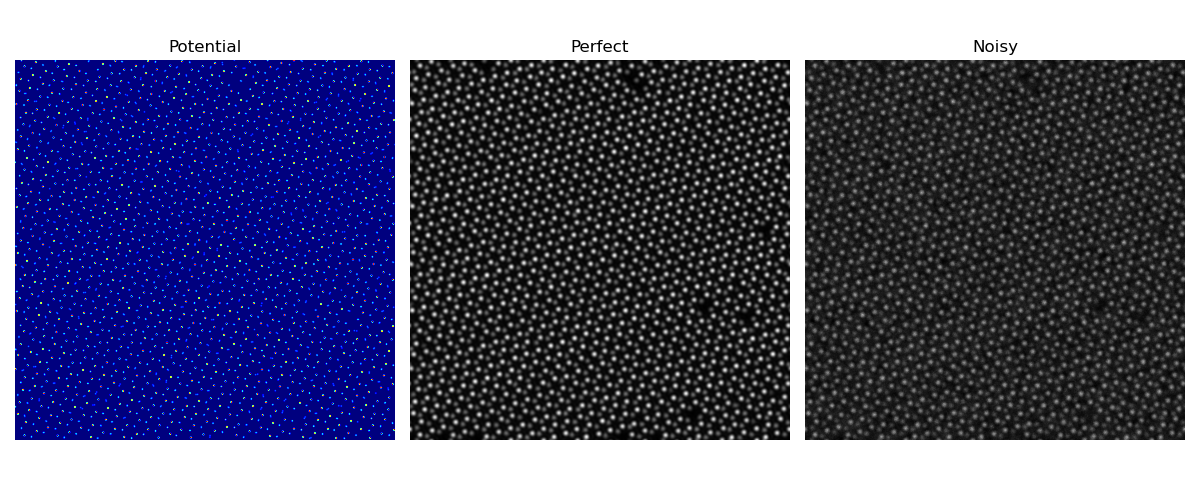

In [13]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 5))

ax[0].set_title('Potential')
ax[0].imshow(potential, cmap='jet', vmax=0.5)
ax[1].set_title('Perfect')
ax[1].imshow(perfect_image, cmap='gray')
ax[2].set_title('Noisy')
ax[2].imshow(sim_im, cmap='gray')

for a in ax:
    a.axis('off')
fig.tight_layout()


In [14]:
masks_l1 = dg.get_masks(xtal, axis_extent = axis_extent, pixel_size = pixel_size, radius = 5, mode='one_hot')


fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 5))  

for i in range(len(masks_l1)):
    ax[0,i].imshow(masks_l1[i,:,:], cmap='gray')
    ax[1,i].imshow(masks_l2[i,:,:], cmap='gray')

for a in ax.ravel():
    a.axis('off')
fig.tight_layout()

NameError: name 'axis_extent' is not defined

In [ ]:
# Crop and zoom
batch_ims = dg.shotgun_crop(noisy_image, crop_size = crop_size, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, roi = 'middle')
batch_ims = batch_ims.reshape(-1,crop_size,crop_size)

batch_masks = dg.shotgun_crop(masks, crop_size = crop_size, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, return_binary = True, roi = 'middle')
batch_masks = batch_masks.reshape(-1,len(masks),crop_size,crop_size)
batch_masks = (batch_masks > 0.5).astype(int) # binarize the masks

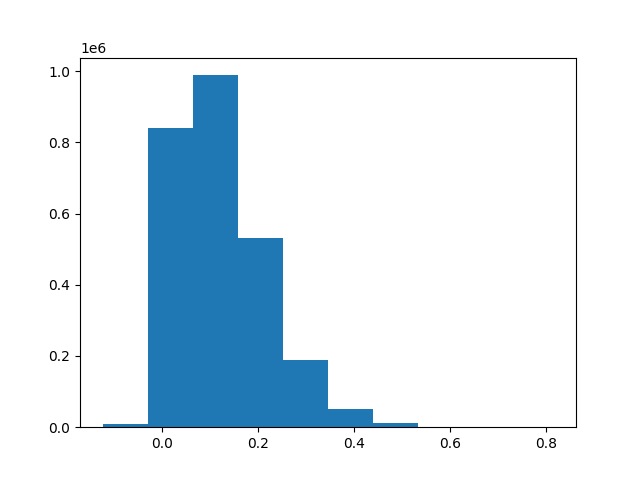

In [ ]:
plt.figure()
plt.hist(batch_ims.flatten());

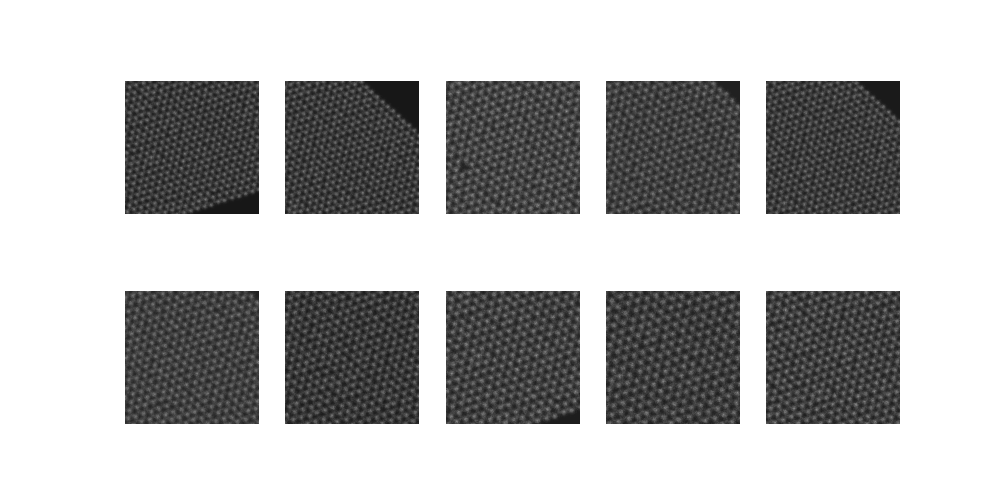

In [ ]:
fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10, 5))
for a, b_im in zip(ax.ravel(), batch_ims):
    a.imshow(b_im, cmap='gray')
    a.axis('off')

In [ ]:
print(batch_ims.shape, '\n',batch_masks.shape)

(10, 512, 512) 
 (10, 3, 512, 512)


IndexError: index 3 is out of bounds for axis 1 with size 3

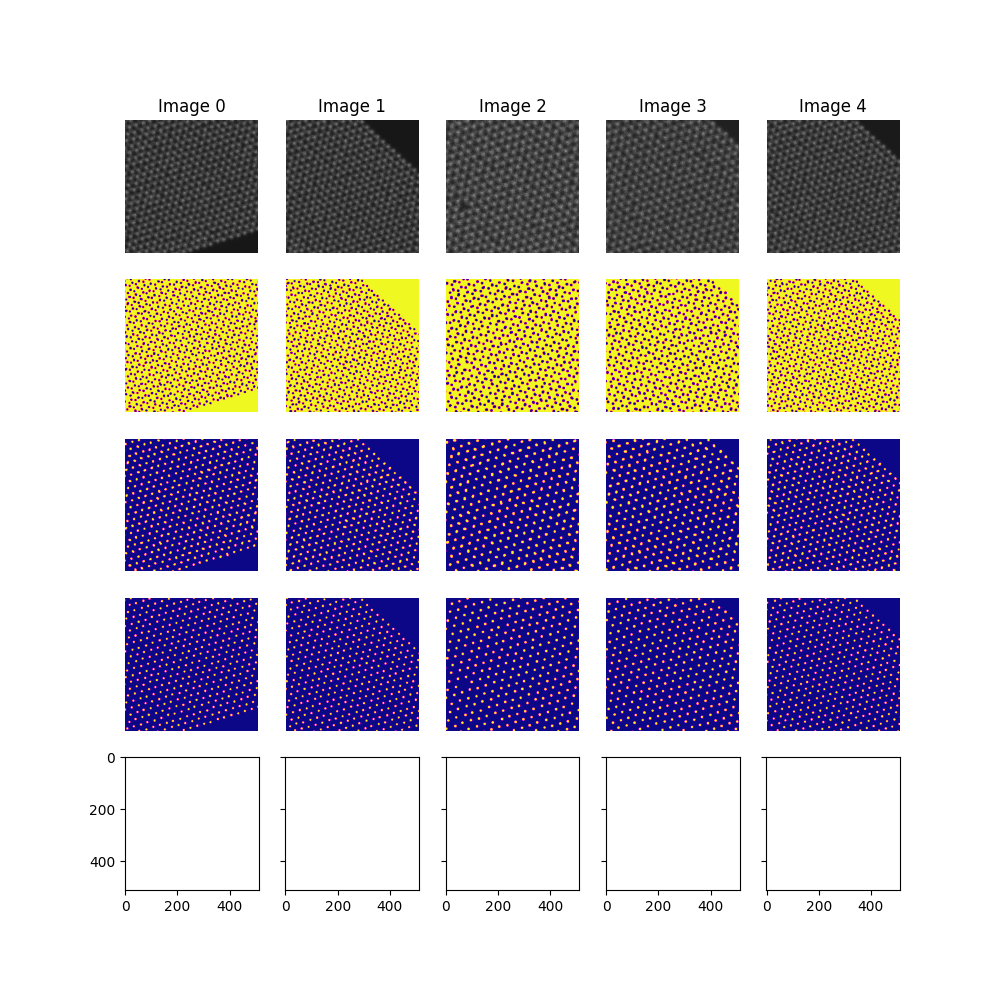

In [ ]:
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(10, 10))

for i, ax in enumerate(axs[0,:].ravel()):
    ax.imshow(batch_ims[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Image {i}')
for x in range(1,5):
    for y in range(5):
        axs[x,y].imshow(batch_masks[y,x-1], cmap='plasma')
        axs[x,y].axis('off')
fig.tight_layout()

In [ ]:
image_counter = 0
# save images and masks
for image, label_set in zip(batch_ims, batch_masks):
    image = image - np.min(image)
    image = image / np.max(image)
    img = Image.fromarray((image * 255).astype(np.uint8))
    img.save(f'./MoS2gb_dataset/images/image_{image_counter:04d}.png')

    os.mkdir(f'./MoS2gb_dataset/labels/label_{image_counter:04d}/')
    for j, label in enumerate(label_set):
        img = Image.fromarray((label * 255).astype(np.uint8))
        img.save(f'./MoS2gb_dataset/labels/label_{image_counter:04d}/class_{j:01d}.png')
    image_counter += 1



In [ ]:
used_seeds = []
# Set numpy randomizer
master_seed = secrets.randbits(128)
while master_seed in used_seeds:
    master_seed = secrets.randbits(128)
used_seeds.append(master_seed)
rng = np.random.default_rng(master_seed)

# Set random params
# --------------------------------------------------
phonon_sigma = rng.uniform(0.05, 0.15)
rotation_l1 = rng.uniform(0, 360)
rotation_l2 = rng.uniform(0, 360)
atom_var = 0.18 #rng.normal(loc = 0.16, scale = 0.01)
airy_disk_size = 1
shot_noise = rng.uniform(0.88, 0.98)
magnification_var = rng.uniform(0.2, 0.35)
crop_param_seed = rng.integers(0, 1000000)
# --------------------------------------------------

In [ ]:
# Read in xtal
print('reading cif files:')
xtal_l1 = read('./crystal_files/graphene.cif') * (40,40,1)
xtal_l2 = read('./crystal_files/graphene.cif') * (40,40,1)
combined_xtal = xtal_l1 + xtal_l2
positions = combined_xtal.get_positions()[:, :2]
xmin, xmax = np.min(positions[:, 0]), np.max(positions[:, 0])
ymin, ymax = np.min(positions[:, 1]), np.max(positions[:, 1])
borders = 1
axis_extent = (xmin - borders, xmax + borders, ymin - borders, ymax + borders)

# Generate training dataset
n_images = 10
crop_size = 256
pixel_size = 0.078125 # Angstrom/pixel, determines number of points, aka resolution of maps.  the xtal determines the fov
n_crops = 2 # number of crops per large image

print('making images:')
image_counter = 0
used_seeds = []
while image_counter < n_images:
    print(image_counter, ' out of ', n_images)

    # Set numpy randomizer
    master_seed = secrets.randbits(128)
    while master_seed in used_seeds:
        master_seed = secrets.randbits(128)
    used_seeds.append(master_seed)
    rng = np.random.default_rng(master_seed)

    # Set random params
    # --------------------------------------------------
    phonon_sigma = rng.uniform(0.02, 0.1)
    rotation_l1 = rng.uniform(0, 360)
    rotation_l2 = rng.uniform(0, 360)
    atom_var = rng.normal(loc = 0.175, scale = 0.01)
    airy_disk_size = 1
    shot_noise = rng.uniform(0.6, 0.9)
    magnification_var = rng.uniform(0.2, 0.35)
    crop_param_seed = rng.integers(0, 1000000)
    # --------------------------------------------------

    # Make xtal (with random rotations and vacancies)
    rot_xtal_l1 = dg.get_xtal_matrix(xtal = xtal_l1, n_cells = (1,1,1), rotation = rotation_l1, n_vacancies = 10, phonon_sigma = phonon_sigma, axis_extent = axis_extent)
    rot_xtal_l2 = dg.get_xtal_matrix(xtal = xtal_l2, n_cells = (1,1,1), rotation = rotation_l2, n_vacancies = 10, phonon_sigma = phonon_sigma, axis_extent = axis_extent)


    # Make potential and psf (with random atom_size and psf size)
    potential_l1 = dg.get_pseudo_potential(xtal = rot_xtal_l1, pixel_size = pixel_size, sigma = atom_var, axis_extent = axis_extent)
    potential_l2 = dg.get_pseudo_potential(xtal = rot_xtal_l2, pixel_size = pixel_size, sigma = atom_var, axis_extent = axis_extent)
    potential_l1, potential_l2 = potential_l1 / np.max(potential_l1), potential_l2 / np.max(potential_l2)
    potential_total = potential_l1 + potential_l2

    # Make point spread function
    psf = dg.get_point_spread_function(airy_disk_radius = airy_disk_size, size = 32)
    psf_resize = dg.resize_image(np.array(psf), n = max(potential_total.shape)) # for plotting on same axes as image

    # Make image, masks and add shot noise
    perfect_image = dg.convolve_kernel(potential_total, psf)
    noisy_image = dg.add_poisson_noise(perfect_image, shot_noise = shot_noise)
    masks_l1 = dg.get_masks(rot_xtal_l1, axis_extent = axis_extent, pixel_size = pixel_size, radius = 5, mode='one_hot')
    masks_l2 = dg.get_masks(rot_xtal_l2, axis_extent = axis_extent, pixel_size = pixel_size, radius = 5, mode='one_hot')

    # Crop and zoom
    batch_ims = dg.shotgun_crop(noisy_image, crop_size = crop_size, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, roi = 'middle')
    batch_ims = batch_ims.reshape(-1,crop_size,crop_size)
    
    batch_masks_l1 = dg.shotgun_crop(masks_l1, crop_size = crop_size, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, return_binary = True, roi = 'middle')
    batch_masks_l2 = dg.shotgun_crop(masks_l2, crop_size = crop_size, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, return_binary = True, roi = 'middle')
    batch_masks = np.stack((batch_masks_l1, batch_masks_l2), axis=1)
    batch_masks = batch_masks.reshape(-1,len(masks_l1)+len(masks_l2),crop_size,crop_size)
    batch_masks = (batch_masks > 0.5).astype(int) # binarize the masks

    # save images and masks
    for image, label_set in zip(batch_ims, batch_masks):
        image = image - np.min(image)
        image = image / np.max(image)
        img = Image.fromarray((image * 255).astype(np.uint8))
        #img.save(f'/Users/austin/desktop/G_dataset/images/image_{image_counter:04d}.png')

        # os.makedirs(f'/Users/austin/desktop/G_dataset/labels/label_{image_counter:04d}/', exist_ok=True)
        for j, label in enumerate(label_set):
            img = Image.fromarray((label * 255).astype(np.uint8))
            #img.save(f'/Users/austin/desktop/G_dataset/labels/label_{image_counter:04d}/class_{j:01d}.png')
            
        image_counter += 1

reading cif files:
making images:
0  out of  10
2  out of  10
4  out of  10
6  out of  10
8  out of  10


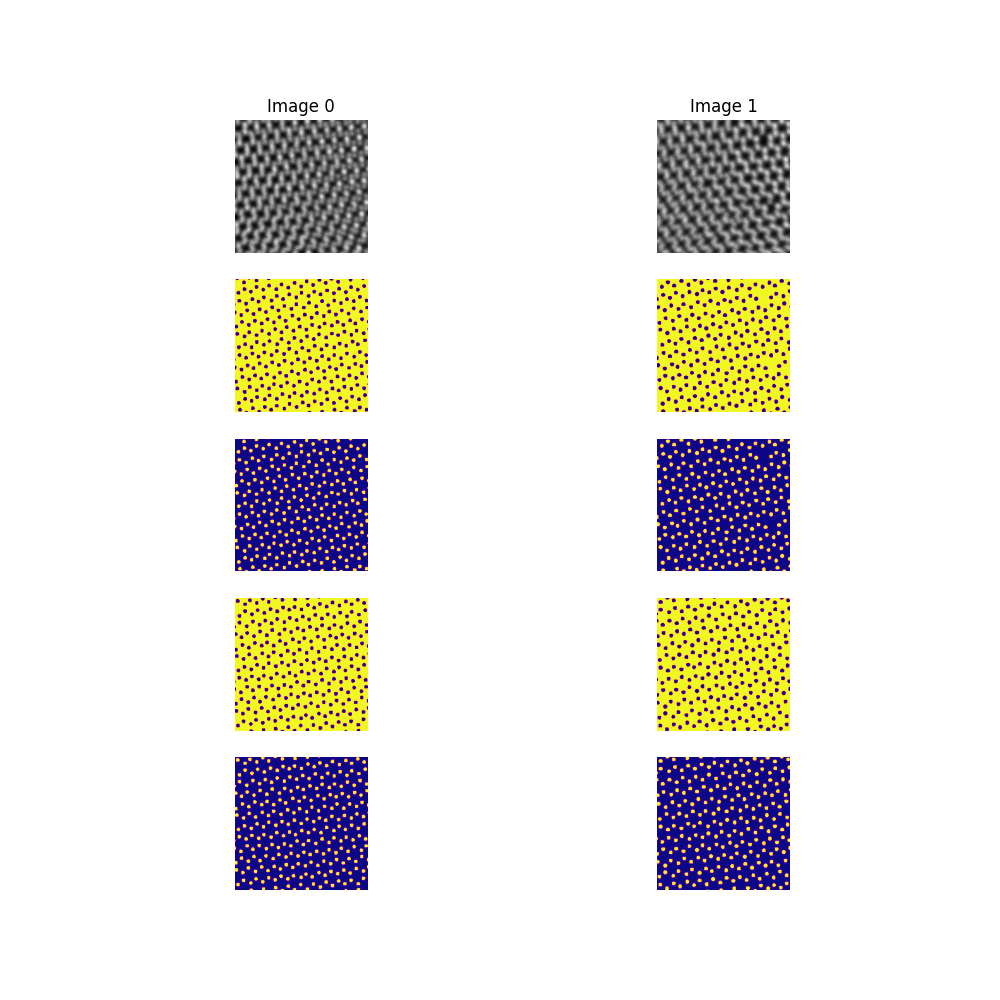

In [ ]:
# plot them
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10, 10))

for i, ax in enumerate(axs[0,:].ravel()):
    ax.imshow(batch_ims[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Image {i}')

for x in range(1,5):
    for y in range(2):
        ax = axs[x,y]
        ax.imshow(batch_masks[y,x-1], cmap='plasma')
        ax.axis('off')

In [ ]:
# masks = dg.get_masks(rot_xtal, axis_extent = axis_extent, pixel_size = pixel_size, radius = 5, mode='integer')
# 
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5, 5))  
# 
# ax.imshow(masks, cmap='viridis')